# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: David Diao

**ID**: zd46

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE 4750/HW/hw5-hw-5-david`
   Installed LERC_jll ───────────── v4.0.0+0
   Installed JpegTurbo_jll ──────── v3.0.4+0
   Installed LoggingExtras ──────── v1.1.0
   Installed OffsetArrays ───────── v1.14.1
   Installed MutableArithmetics ─── v1.5.2
   Installed PlotUtils ──────────── v1.4.3
   Installed StaticArrays ───────── v1.9.8
   Installed GR_jll ─────────────── v0.73.8+0
   Installed NetworkLayout ──────── v0.4.7
   Installed HTTP ───────────────── v1.10.10
   Installed DataFrames ─────────── v1.7.0
   Installed Cairo_jll ──────────── v1.18.2+1
   Installed Libgpg_error_jll ───── v1.50.0+0
   Installed HiGHS_jll ──────────── v1.8.1+0
   Installed ColorSchemes ───────── v3.27.1
   Installed FFMPEG ─────────────── v0.4.2
   Installed XZ_jll ─────────────── v5.6.3+0
   Installed Bzip2_jll ──────────── v1.0.8+2
   Installed CodecBzip2 ─────────── v0.8.4
   Installed SentinelArrays ─────── v1.4.7
   Installed MathOptInterface ───── v1.34.0
   Install

In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

In [5]:
using Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/HW/hw5-hw-5-david/Project.toml`
    Updating `~/Desktop/BEE 4750/HW/hw5-hw-5-david/Manifest.toml`
  [8e850b90] ↑ libblastrampoline_jll v5.8.0+1 ⇒ v5.11.0+0
   Resolving package versions...
   Installed GLPK_jll ─ v5.0.1+1
    Updating `~/Desktop/BEE 4750/HW/hw5-hw-5-david/Project.toml`
  [60bf3e95] + GLPK v1.2.1
    Updating `~/Desktop/BEE 4750/HW/hw5-hw-5-david/Manifest.toml`
  [60bf3e95] + GLPK v1.2.1
  [e8aa6df9] + GLPK_jll v5.0.1+1
  [781609d7] + GMP_jll v6.2.1+6
Precompiling project...
  ✓ GLPK_jll
  ✓ GLPK
  2 dependencies successfully precompiled in 4 seconds. 234 already precompiled.


## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

In [17]:
using JuMP
using GLPK

# Cities data
waste = [100, 90, 120] 
dist_city_LF = [5, 15, 13]
dist_city_MRF = [30, 25, 45]
dist_city_WTE = [15, 10, 20]

dist_MRF_LF = 32
dist_MRF_WTE = 15
dist_WTE_LF = 18

LF_cap = 200
MRF_cap = 350
WTE_cap = 210

# Costs
LF_fixed = 2000
MRF_fixed = 1500
WTE_fixed = 2500

LF_tipping = 50
MRF_tipping = 7
WTE_tipping = 60
MRF_recycle_cost = 40
transport_cost = 1.5

recycle_rate = 0.4    # MRF recycling rate
ash_frac = 0.16       # WTE ash rate

model = Model(GLPK.Optimizer)

@variables(model, begin
    x_city_LF[i=1:3] >= 0   # Waste from city i to LF
    x_city_MRF[i=1:3] >= 0  # Waste from city i to MRF
    x_city_WTE[i=1:3] >= 0  # Waste from city i to WTE

    y_MRF_LF >= 0           # Residue from MRF to LF
    y_MRF_WTE >= 0          # Residue from MRF to WTE

    use_LF, Bin
    use_MRF, Bin
    use_WTE, Bin
end)

@expression(model, X_MRF, sum(x_city_MRF[i] for i=1:3))
@expression(model, X_WTE, sum(x_city_WTE[i] for i=1:3) + y_MRF_WTE)
@expression(model, LF_load, sum(x_city_LF[i] for i=1:3) + y_MRF_LF + ash_frac*X_WTE)

# City supply constraints
for i in 1:3
    @constraint(model, x_city_LF[i] + x_city_MRF[i] + x_city_WTE[i] == waste[i])
end

# MRF residue balance
@constraint(model, y_MRF_LF + y_MRF_WTE == (1 - recycle_rate)*X_MRF)

# Different site capacity constraints
@constraint(model, X_MRF <= MRF_cap)
@constraint(model, X_WTE <= WTE_cap)
@constraint(model, LF_load <= LF_cap)

# Linking binary variables to usage
@constraint(model, use_LF >= LF_load/100000)
@constraint(model, use_MRF >= X_MRF/100000)
@constraint(model, use_WTE >= X_WTE/100000)

# Fixed cost
@expression(model, fixed_cost, LF_fixed*use_LF + MRF_fixed*use_MRF + WTE_fixed*use_WTE)

# Tipping costs
@expression(model, tipping_cost,
    LF_tipping*LF_load + MRF_tipping*X_MRF + WTE_tipping*X_WTE
)

# Recycling cost at MRF
@expression(model, recycle_cost, MRF_recycle_cost*(recycle_rate*X_MRF))

# Transportation cost
@expression(model, trans_cost,
    # City to LF
    sum(x_city_LF[i]*transport_cost*dist_city_LF[i] for i=1:3)
    # City to MRF
    + sum(x_city_MRF[i]*transport_cost*dist_city_MRF[i] for i=1:3)
    # City to WTE
    + sum(x_city_WTE[i]*transport_cost*dist_city_WTE[i] for i=1:3)
    # MRF to LF
    + y_MRF_LF*transport_cost*dist_MRF_LF
    # MRF to WTE
    + y_MRF_WTE*transport_cost*dist_MRF_WTE
    # WTE to LF (ash)
    + (ash_frac*X_WTE)*transport_cost*dist_WTE_LF
)

@objective(model, Min, fixed_cost + tipping_cost + recycle_cost + trans_cost)

optimize!(model)

println("Optimal Objective Value: ", objective_value(model))
println("x_city_LF: ", value.(x_city_LF))
println("x_city_MRF: ", value.(x_city_MRF))
println("x_city_WTE: ", value.(x_city_WTE))
println("y_MRF_LF: ", value(y_MRF_LF))
println("y_MRF_WTE: ", value(y_MRF_WTE))
println("Use LF: ", value(use_LF))
println("Use MRF: ", value(use_MRF))
println("Use WTE: ", value(use_WTE))
println("LF load: ", value(LF_load))
println("MRF load: ", value(X_MRF))
println("WTE load: ", value(X_WTE))


Optimal Objective Value: 27792.857142857145
x_city_LF: [100.0, 0.0, 79.04761904761904]
x_city_MRF: [0.0, 0.0, 0.0]
x_city_WTE: [0.0, 90.0, 40.952380952380985]
y_MRF_LF: 0.0
y_MRF_WTE: 0.0
Use LF: 1.0
Use MRF: 0.0
Use WTE: 1.0
LF load: 200.0
MRF load: 0.0
WTE load: 130.952380952381


Problem 1 thought process: 
To determine the optimal flows, considered each city’s available disposal routes and the costs associated with them. Started by writing down constraints to ensure all waste from each city is included for and that capacities at each site is not overloading. Next, included costs for using each facility, factoring in fixed costs , tipping fees, recycling charges at the MRF, and transportation costs. For instance, sending ash from the WTE to the landfill. Put those condition into a linear optimization model, used a solver to find the least-cost solution as the optimized result. 

The optimal solution is sending City 1 and City 2’s waste directly to the WTE, then disposing of the resulting ash in the LF, while City 3’s waste goes directly to the LF. In this solution, the MRF is not utilized at all. The solution does make sense. Even though the MRF reduces the landfill load by recycling waste, its additional fixed cost, recycling charges, and higher transportation distances that make it more expensive overall. Thus, the combination of WTE and LF provides a simpler and cheaper solution that meets capacity constraints and minimizes total costs.

Diagram: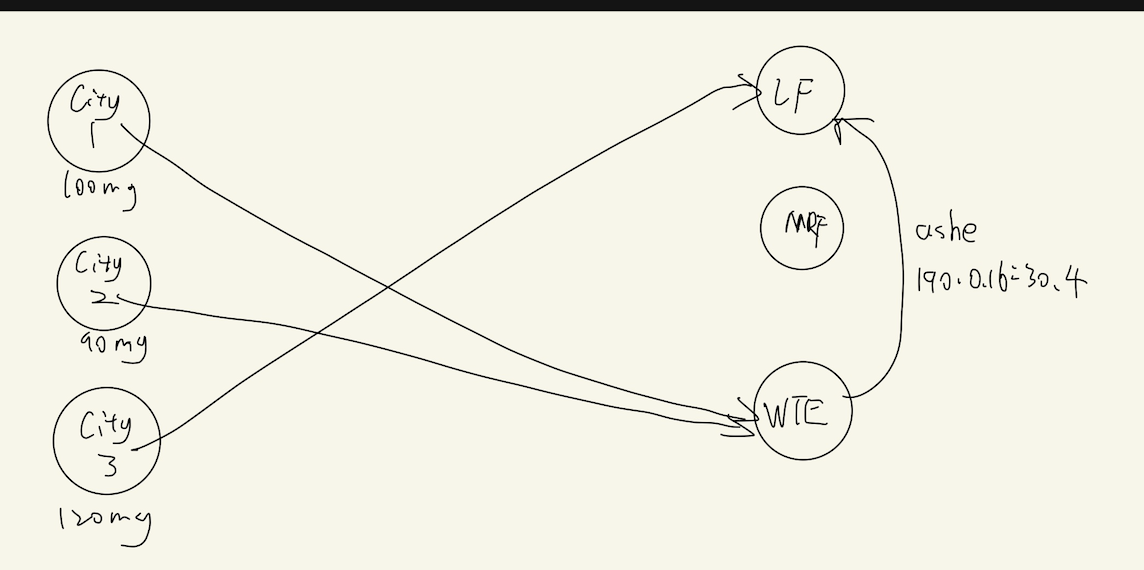 

## References

List any external references consulted, including classmates.